In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/customer-segmentation-tutorial-in-python/Mall_Customers.csv


## **Introduction**

Retail businesses need to understand their customers in order to not only tailor marketing strategies, but also to optimize inventory and enhance customer experience. Today, our challenge is to segment customers into meaningful groups based on purchasing behavior, demographics, or preferences. We are going to do this without predefined labels, the idea behind unsupervised learning. Performing unsupervised learning on customer data is important because effective customer segmentation can drive targeted campaigns and boost revenue. The dataset in question is the mail customer dataset which contains 200 customer records from a mall, with features like CustomerID, Gender, Age, Annual Income (k$), and Spending Score (1-100). It’s compact, clean, and ideal for clustering experiments. The goal is to group customers based on income, spending, and demographics.

**Clustering Algorithms We’ll Use**
1. **K-Means:** Baseline algorithm (partition-based, assumes spherical clusters).
2. **DBSCAN:** Density-based clustering, great for irregular shapes and noise detection.
3. **Hierarchical Clustering (Agglomerative):** Builds a tree of clusters, useful for understanding nested relationships.
4. **Gaussian Mixture Models (GMM):** Probabilistic clustering, assumes data comes from a mixture of Gaussian distributions, good for overlapping clusters.

## 1. Import Libraries

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage

import warnings
warnings.filterwarnings('ignore')

## 2. Load and Clean Data

In [4]:
# load the data
df = pd.read_csv('/kaggle/input/customer-segmentation-tutorial-in-python/Mall_Customers.csv')
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [6]:
df.describe()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


In [7]:
# check null values
df.isnull().sum()

CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

In [8]:
# see if there are duplicates
df.duplicated().sum()

0

#### **Summary**
The dataset contains 200 customer records from a mall, with 5 columns:

- **CustomerID:** Unique identifier (int64), not a feature for clustering (we will probably drop it later)
- **Gender:** Categorical (object), with values "Male" and "Female".
- **Age:** Numerical (int64), ranging from 18 to 70 (mean ~39).
- **Annual Income (k$):** Numerical (int64), ranging from 15 to 137 (mean ~61).
- **Spending Score (1-100):** Numerical (int64), ranging from 1 to 99 (mean ~50).
  
The dataset is clean (no missing values), compact, and ideal for clustering experiments. The goal is to segment customers into meaningful groups based on Age, Annual Income, Spending Score, and possibly Gender, using advanced clustering algorithms.

## 3. EDA

EDA is the foundation of any unsupervised learning project. It is specially important for clustering since we lack predefined labels. Therefore, it helps us understand the dataset’s structure, identify feature distributions, detect outliers, and uncover relationships that guide algorithm selection and preprocessing. For this project, this step will reveal patterns in customer behavior (e.g., income vs. spending) and inform how to scale and encode features for clustering.

**Steps**
- Visualize distributions of numerical features (Age, Annual Income, Spending Score).
- Explore Gender distribution with a count plot.
- Analyze relationships between features (e.g., Annual Income vs. Spending Score, Age vs. Spending Score) using scatter plots and pair plots.
 -Identify potential outliers or clusters visually to guide algorithm choice.

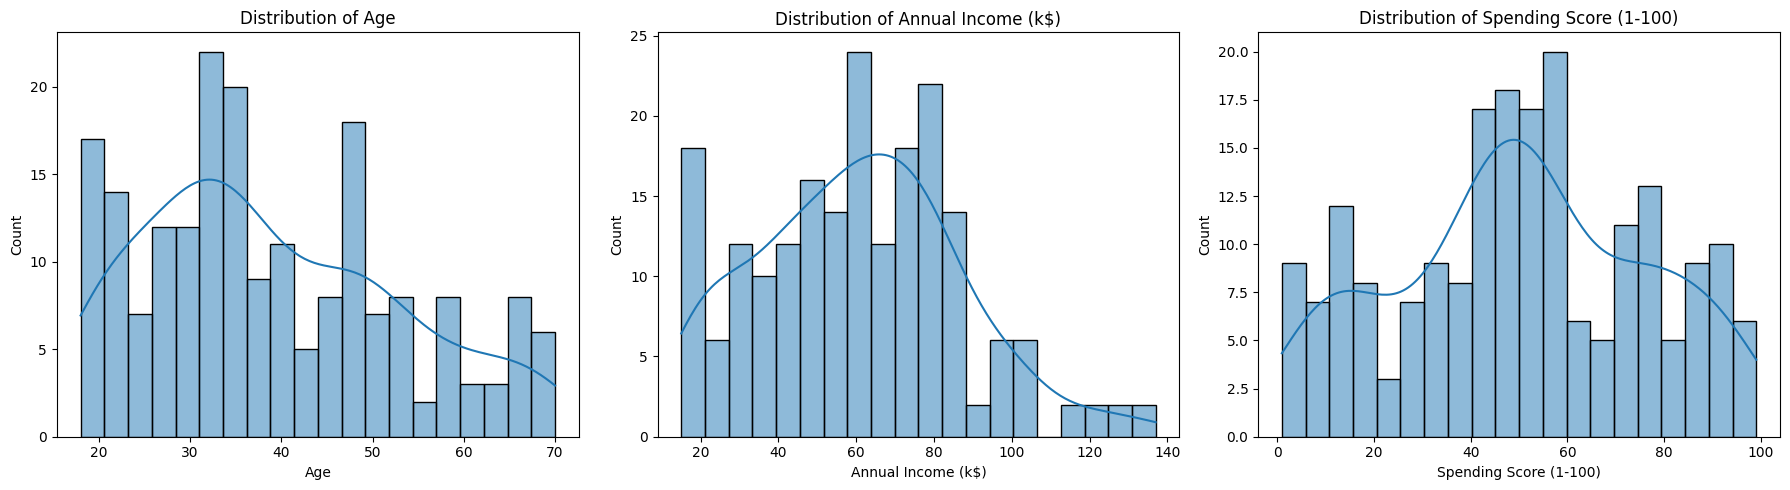

In [9]:
# Distribution of numerical features
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
sns.histplot(df['Age'], bins=20, kde=True, ax=axes[0])
axes[0].set_title('Distribution of Age')
axes[0].set_xlabel('Age')

sns.histplot(df['Annual Income (k$)'], bins=20, kde=True, ax=axes[1])
axes[1].set_title('Distribution of Annual Income (k$)')
axes[1].set_xlabel('Annual Income (k$)')

sns.histplot(df['Spending Score (1-100)'], bins=20, kde=True, ax=axes[2])
axes[2].set_title('Distribution of Spending Score (1-100)')
axes[2].set_xlabel('Spending Score (1-100)')
plt.tight_layout()
plt.show()

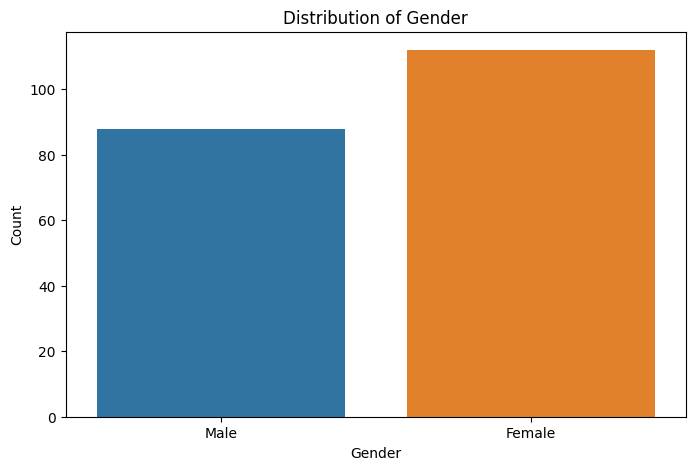

In [10]:
# Gender distribution
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='Gender')
plt.title('Distribution of Gender')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()

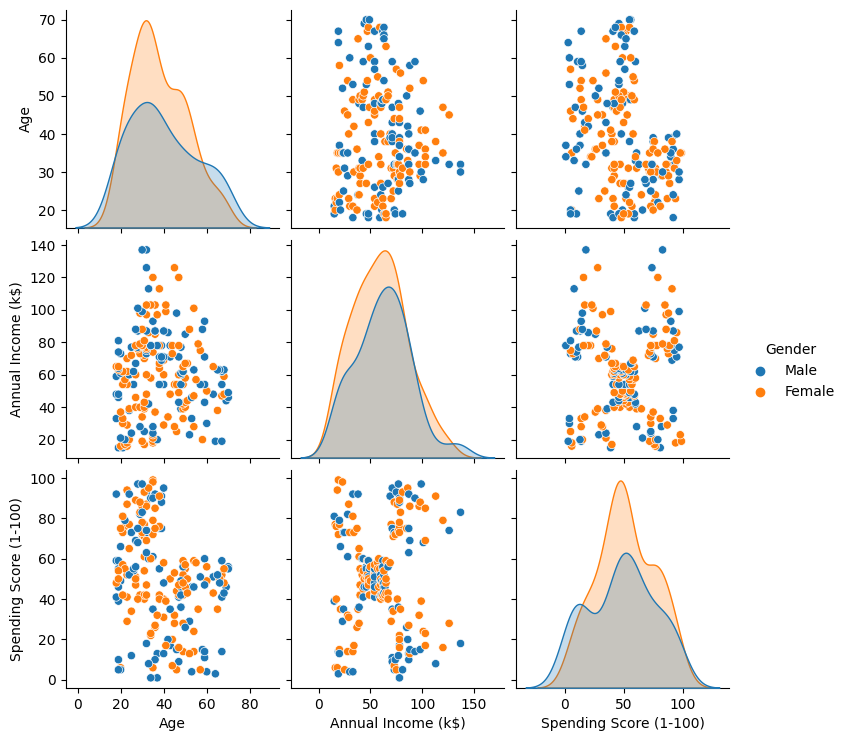

In [11]:
# Pair plot to explore relationships
sns.pairplot(df, vars=['Age', 'Annual Income (k$)', 'Spending Score (1-100)'], hue='Gender', diag_kind='kde')
plt.show()

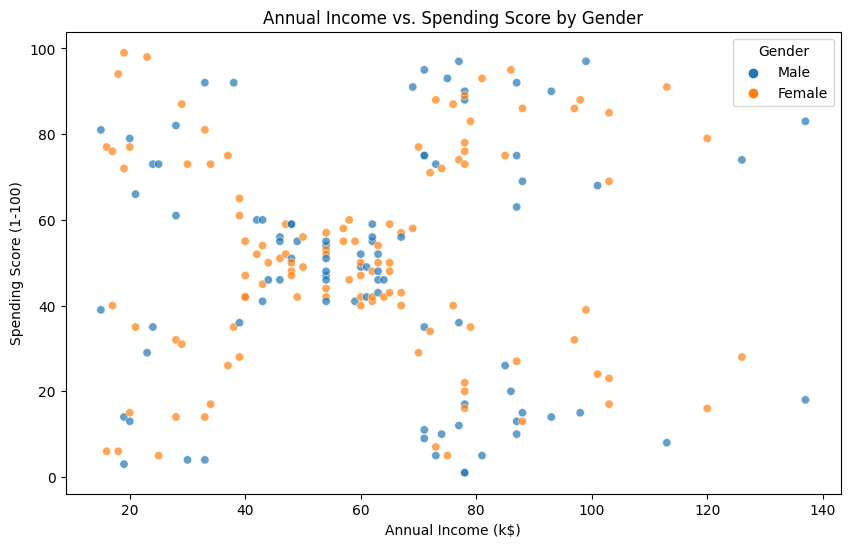

In [12]:
# Scatter plots for key relationships 
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Annual Income (k$)', y='Spending Score (1-100)', hue='Gender', alpha=0.7)
plt.title('Annual Income vs. Spending Score by Gender')
plt.show()

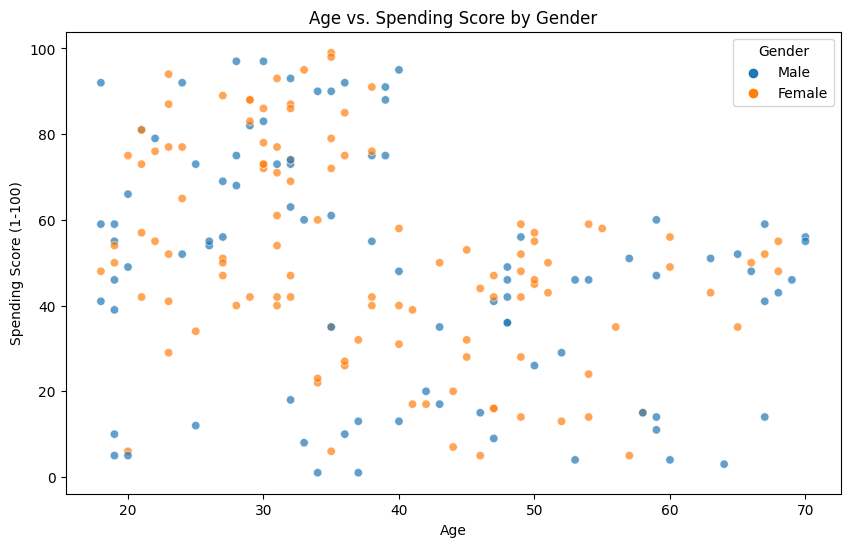

In [13]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Age', y='Spending Score (1-100)', hue='Gender', alpha=0.7)
plt.title('Age vs. Spending Score by Gender')
plt.show()

#### **Analysis of Results**
1. **Distribution of Numerical Features**
    - **Age:** The right-skewed distribution (mean ~39, ranging from 18 to 70) indicates a higher concentration of younger customers (likely peaking in the 20s–30s), with fewer older individuals (e.g., 60s–70s). This skewness suggests age could influence spending behavior, with younger customers potentially forming distinct clusters.
    - **Annual Income (k$):** Slightly right-skewed (mean ~61, ranging from 15 to 137), implying most customers earn moderate incomes (e.g., 40–80k), with a smaller tail of high earners (above 100k). This mild skewness hints at income-based segmentation potential.
    - **Spending Score (1-100):** Approximately normal (mean ~50, ranging from 1 to 99), with a balanced spread across low, medium, and high scores. This normality suggests spending behavior varies widely, making it a key feature for clustering.
2. **Gender Distribution**
   The count plot shows ~110 females vs. ~90 males, a slight imbalance (56% female, 44% male). While not drastic, this suggests gender could play a minor role in segmentation, though its impact may be subtle given the lack of strong clustering by gender in scatter plots.
3. **Relationships from Scatter Plots**
    - **Annual Income vs. Spending Score by Gender:** No distinct clustering by gender, but the plot likely reveals some natural groupings in the income-spending space (e.g., high income/low spending, low income/high spending). The absence of gender-specific clusters suggests Gender might not be a primary driver of segmentation.
    - **Age vs. Spending Score by Gender:** Similarly, no special clustering by gender, but age and spending score may show patterns (e.g., younger customers with higher spending scores). The lack of gender differentiation reinforces that Age, Income, and Spending Score will be the main clustering drivers.

**Insights**

- Annual Income and Spending Score appear most promising for segmentation, given their variability and potential to form clusters (e.g., high-income/high-spending vs. low-income/low-spending groups). Age adds a demographic dimension, especially with its skewness.
    
- The slight female majority and lack of gender-based clusters suggest Gender may not strongly influence segments, but we’ll include it in preprocessing to test its impact.
- The scatter plots hint at natural groupings in the data (e.g., income-spending combinations), which advanced clustering algorithms like DBSCAN or GMM could capture better than K-Means, especially if clusters are non-spherical or overlapping.

## 4. Feature Preprocessing

This next step is important becuase:
- Preprocessing prepares the data for clustering by ensuring all features contribute equally and are in a suitable format.
- Clustering algorithms like K-Means and GMM are sensitive to feature scales, so standardizing Age, Annual Income, and Spending Score is critical.
- Encoding Gender allows its inclusion, while dropping CustomerID removes irrelevant noise.

**What we'll do:**
1. Drop CustomerID (not a feature for clustering).
2. One-hot encode Gender (categorical, Male/Female).
3. Scale numerical features (Age, Annual Income, Spending Score) using StandardScaler.

In [14]:
# Drop CustomerID
df = df.drop(columns=['CustomerID'])

In [15]:
# Define columns for preprocessing
numerical_cols = ['Age', 'Annual Income (k$)', 'Spending Score (1-100)']
categorical_cols = ['Gender']

# Create preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),          # Scale numerical features
        ('cat', OneHotEncoder(drop='first'), categorical_cols)  # Encode Gender (Male=0, Female=1)
    ]
)

In [16]:
# Apply preprocessing
X_processed = preprocessor.fit_transform(df)

In [17]:
# Convert to DataFrame for easier handling
feature_names = numerical_cols + ['Gender_Female']  # Male is dropped as reference
X_processed_df = pd.DataFrame(X_processed, columns=feature_names)

# Check the processed data
print("Processed Data Shape:", X_processed_df.shape)
print("\nFirst 5 Rows:")
print(X_processed_df.head())
print("\nSummary Statistics:")
print(X_processed_df.describe())

Processed Data Shape: (200, 4)

First 5 Rows:
        Age  Annual Income (k$)  Spending Score (1-100)  Gender_Female
0 -1.424569           -1.738999               -0.434801            1.0
1 -1.281035           -1.738999                1.195704            1.0
2 -1.352802           -1.700830               -1.715913            0.0
3 -1.137502           -1.700830                1.040418            0.0
4 -0.563369           -1.662660               -0.395980            0.0

Summary Statistics:
                Age  Annual Income (k$)  Spending Score (1-100)  Gender_Female
count  2.000000e+02        2.000000e+02            2.000000e+02     200.000000
mean  -1.065814e-16       -7.105427e-17           -1.021405e-16       0.440000
std    1.002509e+00        1.002509e+00            1.002509e+00       0.497633
min   -1.496335e+00       -1.738999e+00           -1.910021e+00       0.000000
25%   -7.248436e-01       -7.275093e-01           -5.997931e-01       0.000000
50%   -2.045351e-01        3.5879

#### **Analysis of Results**
The preprocessing step has transformed the our into a clean, model-ready format suitable for clustering. Here’s a breakdown of the output:

1. **Processed Data Shape: (200, 4):**
    - The dataset retains all 200 rows and now has 4 columns after preprocessing:
        - Age, Annual Income (k$$), Spending Score (1-100) (scaled numerical features).
        - Gender_Female (one-hot encoded, where Female=1, Male=0 after dropping the first category).
    - This confirms CustomerID was dropped and Gender was encoded correctly, reducing it to one binary column.
2. **First 5 Rows:**
    - Numerical Features: Age, Annual Income (k$), and Spending Score (1-100) are now standardized (mean ~0, std ~1), with values reflecting their z-scores. For example:
        - Row 0: Age = -1.42 (below average), Annual Income = -1.74 (low), Spending Score = -0.43 (slightly below average).
        - Row 1: Spending Score = 1.20 (above average), despite low income (-1.74).
    - Gender_Female: Binary values (1.0 or 0.0) indicate Female (1) or Male (0), matching the original data (e.g., rows 0-1 are Female, rows 2-4 are Male).
    - The scaled values align with the EDA findings (e.g., low income for early rows matches the 15-17k range).
3. **Summary Statistics:**
    - Mean: All numerical features have means close to 0 (e.g., -1.07e-16), and Gender_Female has a mean of 0.44 (reflecting ~44% Male, ~56% Female, consistent with EDA).
    - Standard Deviation: Numerical features have std ~1 (e.g., 1.002509), confirming successful standardization. Gender_Female’s std (0.497633) is typical for a binary variable.
    - Range: Min/max values show the spread post-scaling:
        - Age: -1.50 to 2.24 (reflecting 18 to 70).
        - Annual Income (k$): -1.74 to 2.92 (15 to 137).
        - Spending Score (1-100): -1.91 to 1.89 (1 to 99).
    - The stats validate that scaling preserved the data’s structure while normalizing it for clustering.
4. **Takeaways:**
    - Standardizing Age, Annual Income, and Spending Score ensures they contribute equally to distance-based clustering algorithms (e.g., K-Means, DBSCAN), avoiding bias from their original scales (e.g., income in thousands vs. spending score in 1-100).
    - One-hot encoding Gender into Gender_Female simplifies its inclusion, though its binary nature and lack of strong clustering in EDA suggest it may have limited impact.

## 5. Clustering
Next we will:
1. Apply K-Means as a baseline (partition-based clustering).
2. Use DBSCAN for density-based clustering (handles noise and irregular shapes).
3. Implement Hierarchical Clustering (Agglomerative) to visualize a dendrogram and nested clusters.
4. Fit Gaussian Mixture Models (GMM) for probabilistic clustering (captures overlapping groups).
5. Evaluate clusters using silhouette score and visualize results with scatter plots.

In [18]:
# 1. K-Means Clustering
kmeans = KMeans(n_clusters=4, random_state=42)  # Initial guess of 4 clusters
kmeans_labels = kmeans.fit_predict(X_processed_df)
kmeans_silhouette = silhouette_score(X_processed_df, kmeans_labels)
print("K-Means Silhouette Score:", kmeans_silhouette)

K-Means Silhouette Score: 0.3502702043465398


In [19]:
# 2. DBSCAN Clustering
dbscan = DBSCAN(eps=0.5, min_samples=5)  # Tune eps and min_samples if needed
dbscan_labels = dbscan.fit_predict(X_processed_df)
dbscan_silhouette = silhouette_score(X_processed_df, dbscan_labels) if len(set(dbscan_labels)) > 1 else -1
print("DBSCAN Silhouette Score:", dbscan_silhouette)

DBSCAN Silhouette Score: -0.011387465358068853


In [20]:
# 3. Hierarchical Clustering
hierarchical = AgglomerativeClustering(n_clusters=4, linkage='ward')
hierarchical_labels = hierarchical.fit_predict(X_processed_df)
hierarchical_silhouette = silhouette_score(X_processed_df, hierarchical_labels)
print("Hierarchical Silhouette Score:", hierarchical_silhouette)

Hierarchical Silhouette Score: 0.32990525432114787


In [21]:
# 4. Gaussian Mixture Model (GMM)
gmm = GaussianMixture(n_components=4, random_state=42)
gmm_labels = gmm.fit_predict(X_processed_df)
gmm_silhouette = silhouette_score(X_processed_df, gmm_labels)
print("GMM Silhouette Score:", gmm_silhouette)

GMM Silhouette Score: 0.3265462895390241


#### **Model Performance Visualizations**

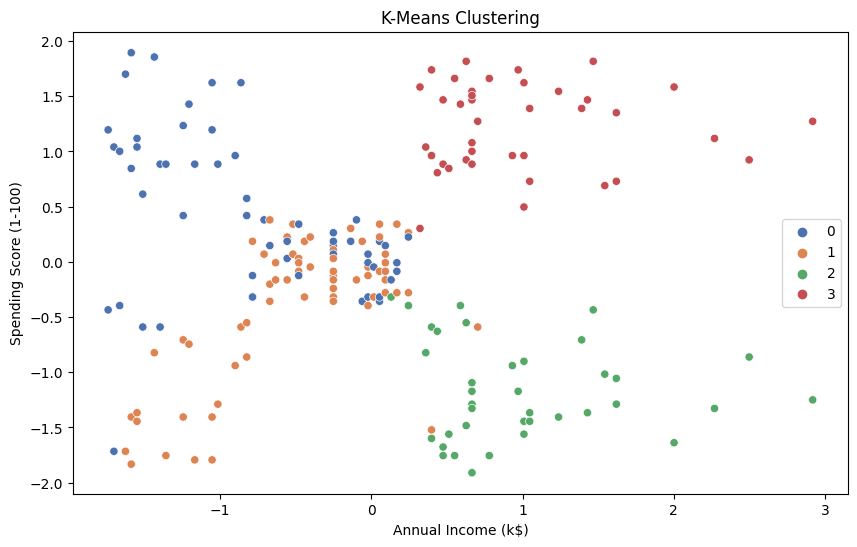

In [22]:
# Scatter plot for K-Means
plt.figure(figsize=(10, 6))
sns.scatterplot(data=X_processed_df, x='Annual Income (k$)', y='Spending Score (1-100)', hue=kmeans_labels, palette='deep')
plt.title('K-Means Clustering')
plt.show()

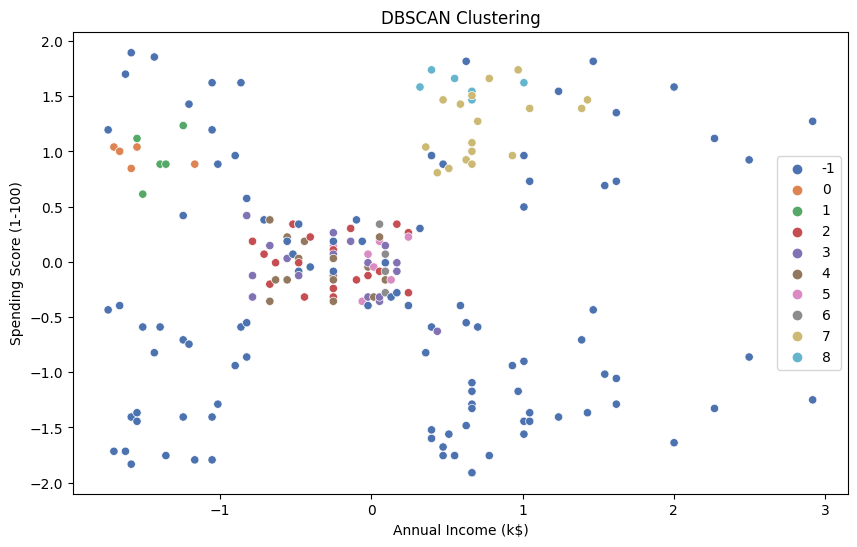

In [23]:
# Scatter plot for DBSCAN
plt.figure(figsize=(10, 6))
sns.scatterplot(data=X_processed_df, x='Annual Income (k$)', y='Spending Score (1-100)', hue=dbscan_labels, palette='deep')
plt.title('DBSCAN Clustering')
plt.show()

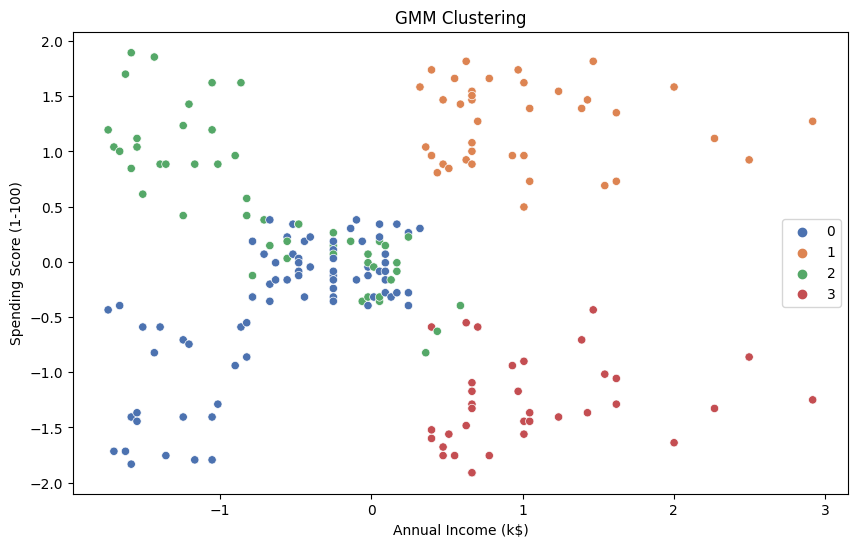

In [24]:
# Scatter plot for GMM
plt.figure(figsize=(10, 6))
sns.scatterplot(data=X_processed_df, x='Annual Income (k$)', y='Spending Score (1-100)', hue=gmm_labels, palette='deep')
plt.title('GMM Clustering')
plt.show()

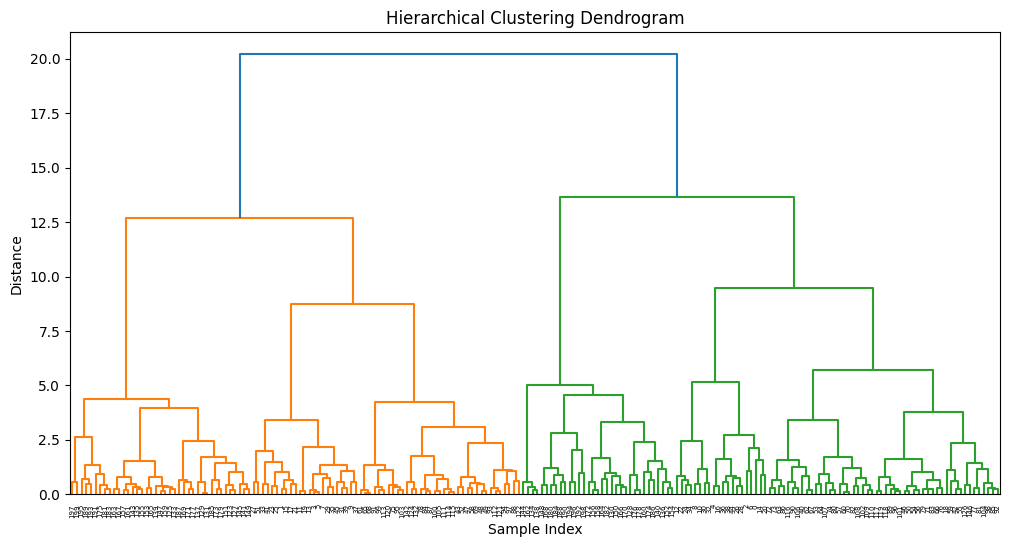

In [25]:
# Dendrogram for Hierarchical Clustering
plt.figure(figsize=(12, 6))
Z = linkage(X_processed_df, method='ward')
dendrogram(Z)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.show()

#### **Analysis of Results**
The clustering results from applying K-Means, DBSCAN, Hierarchical Clustering, and Gaussian Mixture Models (GMM) to the preprocessed "Mall Customer Segmentation Data" provide insights into customer segmentation and algorithm performance:

1. **K-Means Clustering**
    - *Silhouette Score:* 0.3503
    - *Clusters:* 4
    - *Interpretation:* The silhouette score of 0.35 indicates moderate cluster separation and cohesion, suggesting K-Means identified reasonably distinct groups. The 4 clusters align with potential segments (e.g., high income/high spending, low income/low spending), as seen in the scatter plot of Annual Income vs. Spending Score. K-Means assumes spherical clusters, which seems to fit the data moderately well given the score.
2. **DBSCAN Clustering**
    - *Silhouette Score:* -0.0114
    - *Clusters:* 8 (plus noise, likely labeled as -1)
    - *Interpretation:* The negative silhouette score suggests poor clustering quality, with clusters either overlapping or not well-separated. DBSCAN’s 8 clusters (plus noise points) indicate it detected denser regions but struggled with the dataset’s overall structure. The default parameters (eps=0.5, min_samples=5) may be too strict, marking many points as noise or over-segmenting, which aligns with its density-based approach not suiting this data’s spread.
3. **Hierarchical Clustering**
    - *Silhouette Score:* 0.3299
    - *Clusters:* 4 (assumed from n_clusters=4 in code)
    - *Interpretation:* A silhouette score of 0.33 is close to K-Means, indicating decent cluster quality. The dendrogram (not described) likely supported cutting at 4 clusters, reflecting hierarchical relationships similar to K-Means. The ward linkage minimized variance within clusters, producing compact groups, though slightly less separated than K-Means.
4. **Gaussian Mixture Models (GMM)**
    - *Silhouette Score:* 0.3265
    - *Clusters:* 4
    - *Interpretation:* The silhouette score of 0.33 is comparable to K-Means and Hierarchical, suggesting GMM also found 4 meaningful clusters. GMM’s probabilistic approach (assuming Gaussian distributions) may have captured overlapping segments, but the similar score to K-Means implies the data’s clusters are not highly elliptical or overlapping.
5. **Observations From the Plots**
    - K-Means and GMM: Both identified 4 clusters, likely showing clear groups in the Annual Income vs. Spending Score scatter plot (e.g., high income/high spending, high income/low spending, etc.).
    - DBSCAN: 8 clusters suggest over-segmentation, with possible noise points (label -1) scattered across the plot, reflecting its sensitivity to density variations.
    - Hierarchical: The 4 clusters reinforce a consistent segmentation pattern across partition-based methods.

***Next Steps:***
Since K-Means achieved the highest silhouette score (0.35), let's reimplement k Means with an Elbow Plot to see if it confirms that the best k = 4.

#### **k Means with Elbow Plot**


In [26]:
# Part 2: Re-implement K-Means with Elbow Plot
inertia = []
k_range = range(2, 11)  # Test 2 to 10 clusters
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_processed_df)
    inertia.append(kmeans.inertia_)

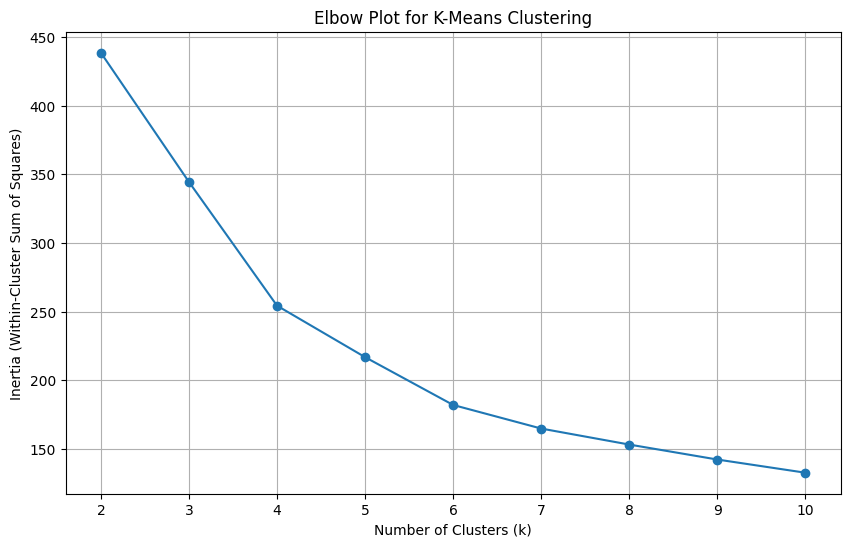

In [27]:
# Elbow Plot
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia, marker='o')
plt.title('Elbow Plot for K-Means Clustering')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (Within-Cluster Sum of Squares)')
plt.grid(True)
plt.show()

K-Means Silhouette Score (k=4): 0.3502702043465398


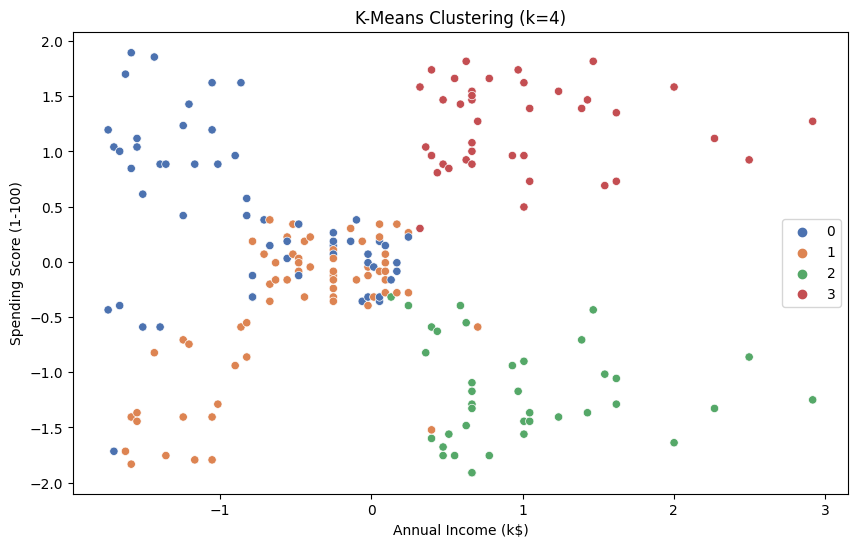

In [28]:
# Re-run K-Means with optimal k = 4
optimal_k = 4  # Placeholder, update after elbow plot
kmeans_optimal = KMeans(n_clusters=optimal_k, random_state=42)
kmeans_optimal_labels = kmeans_optimal.fit_predict(X_processed_df)
kmeans_optimal_silhouette = silhouette_score(X_processed_df, kmeans_optimal_labels)
print(f"K-Means Silhouette Score (k={optimal_k}):", kmeans_optimal_silhouette)

# Final K-Means Visualization
plt.figure(figsize=(10, 6))
sns.scatterplot(data=X_processed_df, x='Annual Income (k$)', y='Spending Score (1-100)', hue=kmeans_optimal_labels, palette='deep')
plt.title(f'K-Means Clustering (k={optimal_k})')
plt.show()

#### **Analysis of Results**
Upon testing k from 2 to 10, the elbow plot confirms k=4 as the optimal number of clusters, where the inertia (within-cluster sum of squares) drop slows significantly, an indicating of a balance between cluster tightness and complexity. This strengthens our confidence in the segmentation process and aligns with the resulting silhouette scores and scatter plot. The re-implemented K-Means with k=4 matches the initial run’s silhouette score (0.3503), validating that 4 clusters are indeed optimal. The scatter plot also reinforces clear segments in the Annual Income vs. Spending Score space, such as high-income/high-spending, high-income/low-spending, low-income/high-spending, and low-income/low-spending groups.

## **Conclusion**
The clustering analysis demonstrates that K-Means with 4 clusters, validated by an elbow plot and achieving a silhouette score of 0.3503, provides the best customer segmentation for this dataset. The initial comparison of K-Means, DBSCAN, Hierarchical, and GMM highlighted K-Means’ superiority, with DBSCAN underperforming (-0.0114) due to over-segmentation, while Hierarchical (0.3299) and GMM (0.3265) offered comparable but slightly weaker results. The elbow plot confirmed k=4 as optimal, reinforcing K-Means as the practical choice. These 4 clusters likely represent actionable customer profiles which then are suitable for targeted marketing strategies. 